In [12]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
    
        for epoch in range(epochs):

            self.discriminator.trainable = True
            
            if epoch <500:
             # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)


                # Train the discriminator
                X = np.concatenate((imgs,gen_imgs))
                y = np.zeros([len(imgs)+len(gen_imgs),2])
                y[0:len(imgs),1] = 1
                y[len(imgs):,0] = 1
                d_loss = self.discriminator.train_on_batch(X, y)
            #             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
            #             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
            #             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1.2-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1.2-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 514       
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________
____

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:205: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.697946, acc.: 60.94%] [G loss: 0.804333]
(492, 100)
(492, 30)
1 [D loss: 0.707862, acc.: 62.50%] [G loss: 0.770768]
2 [D loss: 0.692244, acc.: 53.12%] [G loss: 0.691906]
3 [D loss: 0.668117, acc.: 64.06%] [G loss: 0.625177]
4 [D loss: 0.673777, acc.: 59.38%] [G loss: 0.572971]
5 [D loss: 0.671802, acc.: 57.81%] [G loss: 0.568801]
6 [D loss: 0.665487, acc.: 50.00%] [G loss: 0.532744]
7 [D loss: 0.680824, acc.: 56.25%] [G loss: 0.515999]
8 [D loss: 0.671081, acc.: 46.88%] [G loss: 0.504600]
9 [D loss: 0.689097, acc.: 43.75%] [G loss: 0.511050]
10 [D loss: 0.694453, acc.: 54.69%] [G loss: 0.507489]
11 [D loss: 0.703278, acc.: 53.12%] [G loss: 0.539611]
12 [D loss: 0.727480, acc.: 48.44%] [G loss: 0.609102]
13 [D loss: 0.684452, acc.: 54.69%] [G loss: 0.665952]
14 [D loss: 0.695839, acc.: 59.38%] [G loss: 0.718660]
15 [D loss: 0.675917, acc.: 64.06%] [G loss: 0.775433]
16 [D loss: 0.669678, acc.: 65.62%] [G loss: 0.865043]
17 [D loss: 0.655913, acc.: 64.06%] [G loss: 0.891107]

153 [D loss: 0.614022, acc.: 75.00%] [G loss: 0.844627]
154 [D loss: 0.593509, acc.: 78.12%] [G loss: 0.845889]
155 [D loss: 0.613704, acc.: 71.88%] [G loss: 0.840076]
156 [D loss: 0.586720, acc.: 89.06%] [G loss: 0.834480]
157 [D loss: 0.648547, acc.: 59.38%] [G loss: 0.833334]
158 [D loss: 0.615623, acc.: 76.56%] [G loss: 0.811526]
159 [D loss: 0.580844, acc.: 89.06%] [G loss: 0.831307]
160 [D loss: 0.632723, acc.: 68.75%] [G loss: 0.839641]
161 [D loss: 0.616330, acc.: 75.00%] [G loss: 0.810724]
162 [D loss: 0.644385, acc.: 62.50%] [G loss: 0.792674]
163 [D loss: 0.629443, acc.: 68.75%] [G loss: 0.805200]
164 [D loss: 0.654125, acc.: 60.94%] [G loss: 0.794641]
165 [D loss: 0.631181, acc.: 75.00%] [G loss: 0.815293]
166 [D loss: 0.606688, acc.: 79.69%] [G loss: 0.815631]
167 [D loss: 0.594166, acc.: 78.12%] [G loss: 0.853347]
168 [D loss: 0.606425, acc.: 73.44%] [G loss: 0.835108]
169 [D loss: 0.637065, acc.: 65.62%] [G loss: 0.838235]
170 [D loss: 0.644192, acc.: 65.62%] [G loss: 0.

305 [D loss: 0.568883, acc.: 75.00%] [G loss: 0.899376]
306 [D loss: 0.554668, acc.: 79.69%] [G loss: 0.889103]
307 [D loss: 0.562821, acc.: 79.69%] [G loss: 0.858806]
308 [D loss: 0.597752, acc.: 76.56%] [G loss: 0.856806]
309 [D loss: 0.545758, acc.: 87.50%] [G loss: 0.859659]
310 [D loss: 0.607141, acc.: 70.31%] [G loss: 0.823122]
311 [D loss: 0.545316, acc.: 78.12%] [G loss: 0.808864]
312 [D loss: 0.638029, acc.: 65.62%] [G loss: 0.817954]
313 [D loss: 0.646900, acc.: 56.25%] [G loss: 0.872587]
314 [D loss: 0.528086, acc.: 89.06%] [G loss: 0.886263]
315 [D loss: 0.553611, acc.: 90.62%] [G loss: 0.892940]
316 [D loss: 0.546172, acc.: 90.62%] [G loss: 0.915110]
317 [D loss: 0.581007, acc.: 76.56%] [G loss: 0.947939]
318 [D loss: 0.563756, acc.: 84.38%] [G loss: 0.965348]
319 [D loss: 0.623768, acc.: 73.44%] [G loss: 0.943040]
320 [D loss: 0.537313, acc.: 76.56%] [G loss: 0.938872]
321 [D loss: 0.544579, acc.: 85.94%] [G loss: 0.856354]
322 [D loss: 0.560639, acc.: 81.25%] [G loss: 0.

455 [D loss: 0.519976, acc.: 85.94%] [G loss: 0.903742]
456 [D loss: 0.562332, acc.: 82.81%] [G loss: 0.921095]
457 [D loss: 0.543774, acc.: 93.75%] [G loss: 0.919533]
458 [D loss: 0.565155, acc.: 85.94%] [G loss: 0.956874]
459 [D loss: 0.547202, acc.: 84.38%] [G loss: 0.935624]
460 [D loss: 0.517840, acc.: 95.31%] [G loss: 0.913866]
461 [D loss: 0.559709, acc.: 84.38%] [G loss: 0.914289]
462 [D loss: 0.508266, acc.: 92.19%] [G loss: 0.921719]
463 [D loss: 0.539884, acc.: 84.38%] [G loss: 0.882828]
464 [D loss: 0.577589, acc.: 79.69%] [G loss: 0.898754]
465 [D loss: 0.599870, acc.: 62.50%] [G loss: 0.921094]
466 [D loss: 0.550506, acc.: 87.50%] [G loss: 0.865982]
467 [D loss: 0.538419, acc.: 81.25%] [G loss: 0.910203]
468 [D loss: 0.538982, acc.: 84.38%] [G loss: 0.850667]
469 [D loss: 0.574769, acc.: 76.56%] [G loss: 0.855485]
470 [D loss: 0.539085, acc.: 79.69%] [G loss: 0.876456]
471 [D loss: 0.571074, acc.: 81.25%] [G loss: 0.886020]
472 [D loss: 0.508390, acc.: 92.19%] [G loss: 0.

615 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.642928]
616 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.632562]
617 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.610134]
618 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.629904]
619 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.598228]
620 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.602076]
621 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.573478]
622 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.604861]
623 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.622661]
624 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.614205]
625 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.606614]
626 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.597314]
627 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.615325]
628 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.605275]
629 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.599023]
630 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.601293]
631 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.585767]
632 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.

763 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.495712]
764 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.479941]
765 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.494509]
766 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.473540]
767 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.466074]
768 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.469140]
769 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.461383]
770 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.476874]
771 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.500861]
772 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.493396]
773 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.482416]
774 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.464586]
775 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.467079]
776 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.469899]
777 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.465595]
778 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.468035]
779 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.466747]
780 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.

916 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.352872]
917 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.346522]
918 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.357527]
919 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.349859]
920 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.371322]
921 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.336977]
922 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.341309]
923 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.335643]
924 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.355711]
925 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.360661]
926 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.336226]
927 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.334260]
928 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.327558]
929 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.340243]
930 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.352613]
931 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.335989]
932 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.325584]
933 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.

1063 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.234018]
1064 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.240806]
1065 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.229389]
1066 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.236927]
1067 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.226052]
1068 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.220970]
1069 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.216919]
1070 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.222345]
1071 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.250614]
1072 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.208206]
1073 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.242185]
1074 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.209394]
1075 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.217101]
1076 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.229939]
1077 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.220522]
1078 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.253071]
1079 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.202785]
1080 [D loss: 0.622439, acc.: 6

1211 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.153795]
1212 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.167287]
1213 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.143466]
1214 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.121006]
1215 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.107109]
1216 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.120368]
1217 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.113586]
1218 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.129732]
1219 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.137892]
1220 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.154089]
1221 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.145182]
1222 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.125714]
1223 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.137475]
1224 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.132507]
1225 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.141788]
1226 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.119437]
1227 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.137792]
1228 [D loss: 0.622439, acc.: 6

1355 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.080197]
1356 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.103210]
1357 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.102407]
1358 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.091070]
1359 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.099971]
1360 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.080499]
1361 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.114871]
1362 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.116182]
1363 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.071291]
1364 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.081917]
1365 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.102040]
1366 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.101211]
1367 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.099777]
1368 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.099758]
1369 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.110793]
1370 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.117627]
1371 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.087311]
1372 [D loss: 0.622439, acc.: 6

1512 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.063300]
1513 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.064915]
1514 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.085764]
1515 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.070932]
1516 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.058340]
1517 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.076891]
1518 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.086156]
1519 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.064089]
1520 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.070930]
1521 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.063521]
1522 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.056398]
1523 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.070133]
1524 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.060751]
1525 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.078687]
1526 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.049088]
1527 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.062029]
1528 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.097805]
1529 [D loss: 0.622439, acc.: 6

1656 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.038299]
1657 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.056217]
1658 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.077555]
1659 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.061909]
1660 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.058102]
1661 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.041874]
1662 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.056110]
1663 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.044751]
1664 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.070751]
1665 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.060973]
1666 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.045663]
1667 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.059415]
1668 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.046375]
1669 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.056043]
1670 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.045387]
1671 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.052957]
1672 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.062587]
1673 [D loss: 0.622439, acc.: 6

1813 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.035836]
1814 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.032258]
1815 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.053764]
1816 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.035198]
1817 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.047475]
1818 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.030775]
1819 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.056460]
1820 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.047916]
1821 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.035065]
1822 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.037868]
1823 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.041165]
1824 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.052059]
1825 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.036415]
1826 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.050476]
1827 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.047104]
1828 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.050580]
1829 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.051126]
1830 [D loss: 0.622439, acc.: 6

1970 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.034304]
1971 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.035918]
1972 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.044720]
1973 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021388]
1974 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.054167]
1975 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.042213]
1976 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.031708]
1977 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.042780]
1978 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.031969]
1979 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.043778]
1980 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.033142]
1981 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.038183]
1982 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.044474]
1983 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.046436]
1984 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.042283]
1985 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.030677]
1986 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021536]
1987 [D loss: 0.622439, acc.: 6

2115 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.025941]
2116 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.032151]
2117 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.022944]
2118 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.022630]
2119 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.025142]
2120 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.034418]
2121 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021041]
2122 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.038545]
2123 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.026212]
2124 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.036430]
2125 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.024196]
2126 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.029804]
2127 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.030085]
2128 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.020276]
2129 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.027319]
2130 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.029952]
2131 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.015666]
2132 [D loss: 0.622439, acc.: 6

2262 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012954]
2263 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.031001]
2264 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016304]
2265 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.030832]
2266 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013517]
2267 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021293]
2268 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.034400]
2269 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.028114]
2270 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.031415]
2271 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.031484]
2272 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021591]
2273 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.025808]
2274 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.023263]
2275 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013070]
2276 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017729]
2277 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.025999]
2278 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019738]
2279 [D loss: 0.622439, acc.: 6

2406 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.025697]
2407 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.024283]
2408 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012413]
2409 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.034488]
2410 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009512]
2411 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017534]
2412 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.026223]
2413 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012478]
2414 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016955]
2415 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.024212]
2416 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016212]
2417 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.024834]
2418 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.026457]
2419 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019245]
2420 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016023]
2421 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.028107]
2422 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.018402]
2423 [D loss: 0.622439, acc.: 6

2563 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019607]
2564 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017596]
2565 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019015]
2566 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017664]
2567 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.026090]
2568 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014394]
2569 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011510]
2570 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.023081]
2571 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016517]
2572 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017458]
2573 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.015946]
2574 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014218]
2575 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.018489]
2576 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007232]
2577 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016516]
2578 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007303]
2579 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.021436]
2580 [D loss: 0.622439, acc.: 6

2713 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014644]
2714 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013832]
2715 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019392]
2716 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007625]
2717 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011926]
2718 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017238]
2719 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.016312]
2720 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.019992]
2721 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010039]
2722 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005781]
2723 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012100]
2724 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013854]
2725 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.018496]
2726 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011826]
2727 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013761]
2728 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.022872]
2729 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.015938]
2730 [D loss: 0.622439, acc.: 6

2859 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.018382]
2860 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012914]
2861 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008418]
2862 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012395]
2863 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.017040]
2864 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013648]
2865 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013198]
2866 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008190]
2867 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014737]
2868 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008525]
2869 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014725]
2870 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013292]
2871 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008813]
2872 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007878]
2873 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.014971]
2874 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010900]
2875 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012643]
2876 [D loss: 0.622439, acc.: 6

3011 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009039]
3012 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009020]
3013 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006997]
3014 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007855]
3015 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011017]
3016 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011838]
3017 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007518]
3018 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010578]
3019 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011354]
3020 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010275]
3021 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008706]
3022 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.013223]
3023 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008347]
3024 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010769]
3025 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006569]
3026 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007325]
3027 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012232]
3028 [D loss: 0.622439, acc.: 6

3157 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008646]
3158 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009478]
3159 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009220]
3160 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010058]
3161 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011854]
3162 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004833]
3163 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012410]
3164 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004220]
3165 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006458]
3166 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007491]
3167 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008876]
3168 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011478]
3169 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010578]
3170 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011631]
3171 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.012705]
3172 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009302]
3173 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006002]
3174 [D loss: 0.622439, acc.: 6

3312 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008299]
3313 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008214]
3314 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006111]
3315 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010899]
3316 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007813]
3317 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007829]
3318 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007829]
3319 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008457]
3320 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006883]
3321 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010661]
3322 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011396]
3323 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006508]
3324 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005278]
3325 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006461]
3326 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007731]
3327 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008856]
3328 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004987]
3329 [D loss: 0.622439, acc.: 6

3459 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005898]
3460 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005822]
3461 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005237]
3462 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003540]
3463 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005970]
3464 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006453]
3465 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005099]
3466 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004814]
3467 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004277]
3468 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.009377]
3469 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005043]
3470 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005113]
3471 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.008731]
3472 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004260]
3473 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006934]
3474 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003967]
3475 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003102]
3476 [D loss: 0.622439, acc.: 6

3614 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005896]
3615 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006536]
3616 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.011359]
3617 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006704]
3618 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001497]
3619 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010195]
3620 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004027]
3621 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006236]
3622 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003374]
3623 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006363]
3624 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004772]
3625 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004857]
3626 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005229]
3627 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005292]
3628 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005296]
3629 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003107]
3630 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010419]
3631 [D loss: 0.622439, acc.: 6

3759 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004682]
3760 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003750]
3761 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005710]
3762 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007554]
3763 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002718]
3764 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005075]
3765 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002991]
3766 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.010262]
3767 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003008]
3768 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005640]
3769 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004862]
3770 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003331]
3771 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007707]
3772 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007000]
3773 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004621]
3774 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004859]
3775 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004534]
3776 [D loss: 0.622439, acc.: 6

3911 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006287]
3912 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007887]
3913 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003790]
3914 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007814]
3915 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006657]
3916 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003395]
3917 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002520]
3918 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004071]
3919 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003001]
3920 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003994]
3921 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005918]
3922 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006839]
3923 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002452]
3924 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006177]
3925 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006046]
3926 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004841]
3927 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002499]
3928 [D loss: 0.622439, acc.: 6

4062 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002816]
4063 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005093]
4064 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003744]
4065 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003630]
4066 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006232]
4067 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002142]
4068 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004693]
4069 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003172]
4070 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005752]
4071 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003328]
4072 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001451]
4073 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003982]
4074 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002309]
4075 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002356]
4076 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001739]
4077 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002198]
4078 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002521]
4079 [D loss: 0.622439, acc.: 6

4217 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002086]
4218 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002373]
4219 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001807]
4220 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003773]
4221 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002734]
4222 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.007274]
4223 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004902]
4224 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001716]
4225 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001049]
4226 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.006053]
4227 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003085]
4228 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.005154]
4229 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001313]
4230 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003537]
4231 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004185]
4232 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003997]
4233 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002017]
4234 [D loss: 0.622439, acc.: 6

4373 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002085]
4374 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002244]
4375 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002832]
4376 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003839]
4377 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003752]
4378 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002290]
4379 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001406]
4380 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001645]
4381 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002425]
4382 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002995]
4383 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002051]
4384 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003399]
4385 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002711]
4386 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002686]
4387 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003049]
4388 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003140]
4389 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003439]
4390 [D loss: 0.622439, acc.: 6

4529 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002809]
4530 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001803]
4531 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002554]
4532 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002971]
4533 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003748]
4534 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003237]
4535 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002021]
4536 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002269]
4537 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003560]
4538 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002165]
4539 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002414]
4540 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001979]
4541 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002010]
4542 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.003149]
4543 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002021]
4544 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001886]
4545 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002890]
4546 [D loss: 0.622439, acc.: 6

4682 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000749]
4683 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000785]
4684 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002218]
4685 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002769]
4686 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002694]
4687 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001553]
4688 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.004024]
4689 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002838]
4690 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002130]
4691 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002863]
4692 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002562]
4693 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002260]
4694 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002487]
4695 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002862]
4696 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002886]
4697 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002077]
4698 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002288]
4699 [D loss: 0.622439, acc.: 6

4837 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001064]
4838 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000851]
4839 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002281]
4840 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002359]
4841 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002435]
4842 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002246]
4843 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001948]
4844 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000779]
4845 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001069]
4846 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001550]
4847 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002102]
4848 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002232]
4849 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002688]
4850 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001564]
4851 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002427]
4852 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002668]
4853 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001300]
4854 [D loss: 0.622439, acc.: 6

4995 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001277]
4996 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001606]
4997 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001772]
4998 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002381]
4999 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001113]
5000 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001392]
(492, 100)
(492, 30)
5001 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002327]
5002 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001776]
5003 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002080]
5004 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001087]
5005 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002674]
5006 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000770]
5007 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001730]
5008 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002046]
5009 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002716]
5010 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001106]
5011 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000436]
5012 [D lo

5139 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002189]
5140 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000714]
5141 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000983]
5142 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001135]
5143 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001175]
5144 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001763]
5145 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001606]
5146 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001339]
5147 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001671]
5148 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001770]
5149 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001221]
5150 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001047]
5151 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001416]
5152 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001866]
5153 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001906]
5154 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001649]
5155 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001058]
5156 [D loss: 0.622439, acc.: 6

5295 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000937]
5296 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001439]
5297 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000969]
5298 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000953]
5299 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002032]
5300 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002379]
5301 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001101]
5302 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002147]
5303 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001110]
5304 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001519]
5305 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002079]
5306 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001298]
5307 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000543]
5308 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000357]
5309 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001081]
5310 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.002007]
5311 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000934]
5312 [D loss: 0.622439, acc.: 6

5443 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001396]
5444 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000641]
5445 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000903]
5446 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001281]
5447 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000708]
5448 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000647]
5449 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000754]
5450 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000875]
5451 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001934]
5452 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001082]
5453 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001123]
5454 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001214]
5455 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000758]
5456 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000653]
5457 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000723]
5458 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000592]
5459 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001518]
5460 [D loss: 0.622439, acc.: 6

5593 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000949]
5594 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001607]
5595 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000879]
5596 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000847]
5597 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001078]
5598 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001865]
5599 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000827]
5600 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000752]
5601 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001253]
5602 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001097]
5603 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000668]
5604 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000900]
5605 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001243]
5606 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000949]
5607 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001159]
5608 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000941]
5609 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001023]
5610 [D loss: 0.622439, acc.: 6

5741 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001242]
5742 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001731]
5743 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001444]
5744 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000710]
5745 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001262]
5746 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000870]
5747 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000712]
5748 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000906]
5749 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000876]
5750 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000520]
5751 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000679]
5752 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001297]
5753 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001320]
5754 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000894]
5755 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001220]
5756 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000987]
5757 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001127]
5758 [D loss: 0.622439, acc.: 6

5891 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000680]
5892 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000699]
5893 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000408]
5894 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000398]
5895 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000884]
5896 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000440]
5897 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000489]
5898 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001119]
5899 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000538]
5900 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000458]
5901 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000869]
5902 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000553]
5903 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000492]
5904 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.001292]
5905 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000943]
5906 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000913]
5907 [D loss: 0.622439, acc.: 68.75%] [G loss: 0.000444]
5908 [D loss: 0.622439, acc.: 6

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:307: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<__main__.GAN instance at 0x162120320>

In [11]:
gan.losses

[([0.00044218861, 1.0], 1.9885263),
 ([0.00044218861, 1.0], 5.0112796),
 ([0.00044218861, 1.0], 4.5064564),
 ([0.00044218861, 1.0], 5.2146969),
 ([0.00044218861, 1.0], 5.3448334),
 ([0.00044218861, 1.0], 7.0132294),
 ([0.00044218861, 1.0], 7.4048252),
 ([0.00044218861, 1.0], 5.511447),
 ([0.00044218861, 1.0], 6.1891599),
 ([0.00044218861, 1.0], 6.0113478),
 ([0.00044218861, 1.0], 7.0132294),
 ([0.00044218861, 1.0], 5.5426869),
 ([0.00044218861, 1.0], 6.3654575),
 ([0.00044218861, 1.0], 6.3625994),
 ([0.00044218861, 1.0], 6.0113397),
 ([0.00044218861, 1.0], 6.3505526),
 ([0.00044218861, 1.0], 5.556664),
 ([0.00044218861, 1.0], 6.5664911),
 ([0.00044218861, 1.0], 5.0095286),
 ([0.00044218861, 1.0], 6.2178898),
 ([0.00044218861, 1.0], 6.0113935),
 ([0.00044218861, 1.0], 5.5109363),
 ([0.00044218861, 1.0], 5.5103951),
 ([0.00044218861, 1.0], 7.0134268),
 ([0.00044218861, 1.0], 5.3856149),
 ([0.00044218861, 1.0], 4.4114342),
 ([0.00044218861, 1.0], 5.7776155),
 ([0.00044218861, 1.0], 4.5085

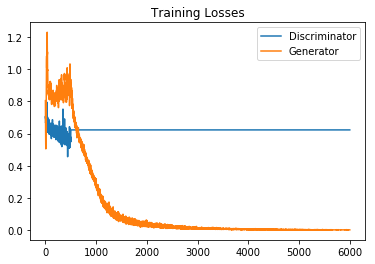

In [13]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

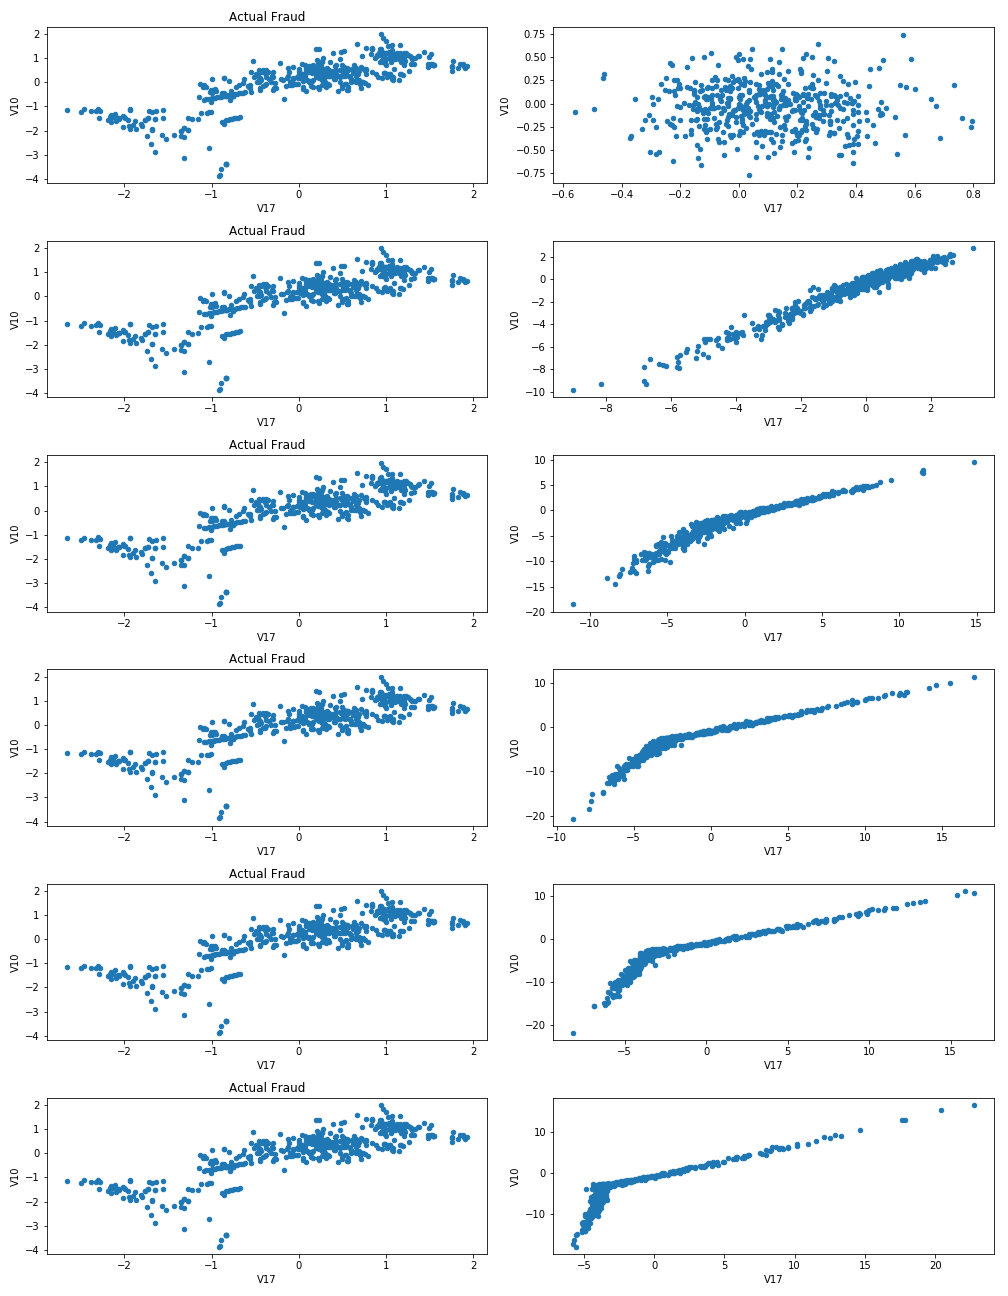

In [14]:
from IPython.display import Image
Image(filename='GANv1.2-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

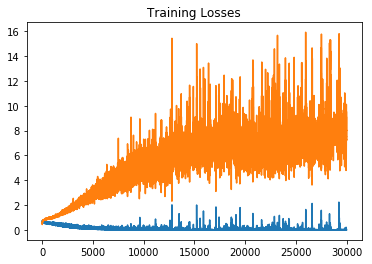

In [68]:
fig